# Project: Create a Chatbot from Movie Scripts data

This notebook contains an implementation for a simple Chatbot model based on the [Cornell movies dataset](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). My goal here is to use the dataset, which is fairly large, to fine-tune an already-existing Transformer model and see how it responds in conversational situations.

A short summary about this project: 
* I used as base the checkpoint for the [T5- Small](https://huggingface.co/google-t5/t5-small) model from Google, as it's general enough (trained on the [Colossal Clean Crawled Corpus](https://www.tensorflow.org/datasets/catalog/c4)), fairly small (only 60M parameters) and not so computationally expensive to fine-tune in a personal computer or virtual machine, provided it has a GPU.
* I used `transformers` and other Hugging Face libraries as my go-to packages for all model and dataset handling operations.
* As I was starting the project, I found a cool implementation from Matthew Inkawhich, in which he trained a transformer model from scratch using this dataset using PyTorch. You can check it out [here](https://brsoff.github.io/tutorials/beginner/chatbot_tutorial.html).

In [ ]:
#!pip install --upgrade transformers datasets

---

## 1. Preprocessing the dataset

For this part, I found the fastest option was to manually download the text files and then load them, although they can also be loaded from the `datasets` library. However, keep in mind that either way this is a very heavy dataset that will take some time to load and process.

The zip file with the raw data contains three distinct datasets, but in this case we're only interested in the `moviequotes.scripts.txt` file. Let's explore the file (after loading it to the local directory):

In [1]:
filename = 'moviequotes.scripts.txt' 
with open(filename, 'r', encoding='utf-8') as file:
    for i in range(5):
        line = file.readline()
        print(line)

0 +++$+++ "murderland" +++$+++ 1 +++$+++ announcer +++$+++  +++$+++ Ladies and gentlemen, the official mascot of Murderland.... Scraps the Dog !

1 +++$+++ "murderland" +++$+++ 2 +++$+++ announcer +++$+++  +++$+++ Choose the doorway that starts you on your magical journey into  MURDERLAND !

2 +++$+++ "murderland" +++$+++ 3 +++$+++ johnny +++$+++  +++$+++ I didn't think he'd make it past Scraps.

3 +++$+++ "murderland" +++$+++ 4 +++$+++ bruce +++$+++ 2 +++$+++ Let's just see if he can make it into round two....

4 +++$+++ "murderland" +++$+++ 5 +++$+++ bruce +++$+++  +++$+++ Don't.



As we can tell from the first 5 lines, we have the following syntax:

`{line ID} +++$+++ {movie title} +++$+++ {line number} +++$+++ {character} +++$+++ {reply line ID} +++$+++ {line}`

Where:
* `line ID`: Unique identifier for each line in the present dataset.
* `movie title`: the name of the movie.
* `line number`: the number of a line for a given movie in the present dataset. This helps keep track of the total lines per movie.
* `character`: the person saying the line.
* `reply line ID`: The line ID of the text the current line is responding to.
* `line`: the words spoken by the character.

Let's now turn the dataset into a more organized structure, so we may examine it further.

In [2]:
import pandas as pd

# parse the data line by line
data = []
invalid_lines = []
with open(filename, 'r', encoding='utf-8', errors='ignore') as file:
    for line in file:
        parts = line.strip().split(' +++$+++ ')
        if len(parts) == 6:  # Ensure it has all parts
            data.append(parts)
        else:
            invalid_lines.append(line)

# save to a dataframe
columns = [
    'line_id', 'movie_title', 'movie_line_number',
    'character', 'reply_line_id', 'line'
]
df = pd.DataFrame(data, columns=columns)

# save statistics
print(f"Total valid lines: {len(df)}")
print(f"Total invalid lines: {len(invalid_lines)}")

Total valid lines: 893767
Total invalid lines: 247


We've saved almost 900k lines with a valid structure, while only losing a minimal amount of data during parsing. Let's explore the dataset:

In [3]:
df.sample(5)

,line_id,movie_title,movie_line_number,character,reply_line_id,line
279348,323990,glengarry glen gross,845,lingk,323989,...and...and...
825341,815050,titanic,1019,jack,815049,Almost as good as you.
242266,282910,fight club,449,jack,282909,This could go on for hours.
45997,44506,american history x,828,derek,,Hey.
232079,269334,extract,692,rory,269333,It's bullshit man. We should get a piece of it...


In [4]:
# print summary stats
print(f"Total movies: {len(df["movie_title"].unique())}")

unique_characters = df[['character', 'movie_title']].drop_duplicates()
print(f"Total unique characters: {len(unique_characters)}")

# clear memory
del unique_characters

Total movies: 1068
Total unique characters: 79844


Let's now dive deeper into the lines of the dataset:

         total_words
count  893767.000000
mean       11.680788
std        15.001486
min         1.000000
25%         4.000000
50%         7.000000
75%        14.000000
max      2457.000000


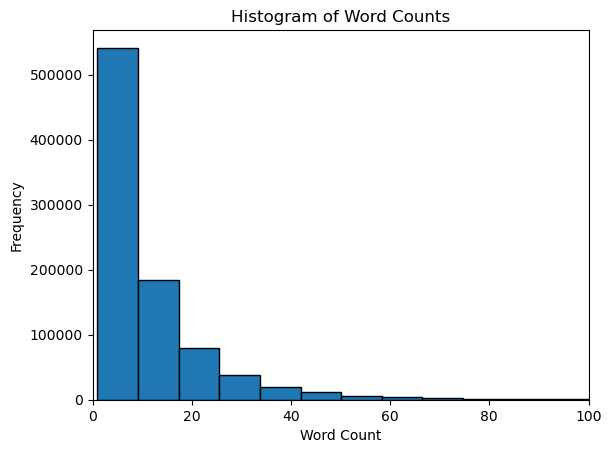

In [5]:
import matplotlib.pyplot as plt

df["total_words"] = df['line'].apply(
    lambda x: len(str(x).split())
)

# check distribution
print(df["total_words"].describe().to_frame())

# plot
df['total_words'].hist(bins=300, edgecolor='black')
plt.title('Histogram of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.grid(False)
plt.show()

As we can see, the average line is fairly short, with a mean of 11.7 words and a median of 7, and the great majority of lines aren't longer than 40 words.

We also have some interesting outliers in the dataset. One of the lines is 2457 words long! an intervention this long probably isn't part of a dialogue, so much as a monologue, and we don't want to include it in our dataset. Imagine talking to a chatbot, only for it to respond to you in several paragraphs of text.

Our rule of thumb will be to cut off any texts longer than 30 words. This way, we train the model to both expect and return reasonable-length texts.

Notice we don't want to cut off very short responses, as this is a natural part of most conversations and it allows it to flow naturally. For example, a "hello" - "hello" interaction is perfectly fine for our purposes.

In [6]:
pd.set_option('display.max_colwidth', None)

df[df["total_words"] == 2457]["line"]

454321    |      Well, At least We've got ONE shrubbery. | |                              OTHER KNIGHTS |      Yes, Yes ... We've Done very Well ...  NI! | |                              TALL KNIGHT |      Ssh! I think somebody's coming.  We'll get them to give us |      another shrubbery. | |                              OTHER KNIGHTS |      Good Idea.  More shrubberies.  As many as possible. | |   Perhaps we start to TRACK BACK from the scene as they go on talking. | |                              TALL KNIGHT |      What shall we call ourselves this time? | |                              KNIGHT |      How about "The knights of Nicky-Nicky"? | | |28 EXTERIOR - DAY | |   A Small group of PEASANTS are being shuffled into a group formation, at the |   apparent direction of someone behind the camera.  A Few coughs |   as they shuffle together.  a moment of silence.  then they burst |   into pleasant  song. | |   Song:   When the trees do blossom full |           and all the hills are gree

Examining further the longest text found in the dataset, we see it's actually a parsing error from the original dataset collection. This text actually contains several interactions between different characters that weren't properly separated, which is even more reason to eliminate it from our dataset. 

In [7]:
# reduce the size of the dataset
initial_size = df.shape[0]

df = df[df["total_words"] <= 30]
final_size = df.shape[0]

print(f"Lost rows after filtering dataset: {initial_size - final_size}")
print(f"Percentage of data lost: {round((initial_size - final_size) / initial_size * 100, 3)}%")

Lost rows after filtering dataset: 62956
Percentage of data lost: 7.044%


Optionally, we can choose to eliminate from the dataset lines that have expletives or insults, so we don't accidentally train a rude chatbot.

To do this, we can load an environment variable called `FORBIDDEN_WORDS`, which contains a list of words to clean from the dataset. Naturally, I won't be repeating here any of the words I loaded on my **.env** file!

In [8]:
import os
import re
import ast

forbidden_words = os.getenv("FORBIDDEN_WORDS", [])

if isinstance(forbidden_words, str):
    try:
        forbidden_words = ast.literal_eval(forbidden_words)
        if not isinstance(forbidden_words, list):
            raise ValueError("env var couldn't be converted to list.")
    except Exception:
        forbidden_words = []

if isinstance(forbidden_words, list) and len(forbidden_words) > 0:
    initial_size = len(df)
    # map words using regex and clear thos rows out
    pattern = r'\b(?:' + '|'.join(map(re.escape, forbidden_words)) + r')\b'
    df = df[~df['line'].str.contains(pattern, case=False, na=False)]
    final_size = len(df)

    print(f"Lost rows after filtering dataset: {initial_size - final_size}")
    print(f"Percentage of data lost: {round((initial_size - final_size) / initial_size * 100, 3)}%")


Lost rows after filtering dataset: 15624
Percentage of data lost: 1.881%


We managed to get rid of some obvious expletive words, but this doesn't mean we got all of them. For a more production-grade application, you could parse the entire dataset's vocabulary, maybe with the help of an LLM, and do a more complete mapping of all forbidden words or expressions.

After doing this cleaning, the final step is to match a prompt to a reply, which is what we want to train the model on. To receive a prompt or question, and to return an answer in relation to it. We do this by mapping the columns `line_id` and `reply_line_id`.

In [9]:
# First, create a mapping from line_id to line
line_dict = df.set_index("line_id")["line"].to_dict()

# Now, create the 'question' and 'answer' pairs
df["question"] = df["reply_line_id"].map(line_dict)
df["answer"] = df["line"]

# Filter to keep only rows where a valid mapping exists
dataset = df[["question", "answer"]].dropna()
print(f"Total rows: {len(dataset)}")
dataset.head()

Total rows: 425928


,question,answer
3,I didn't think he'd make it past Scraps.,Let's just see if he can make it into round two....
5,Don't.,What ?
6,What ?,Don't eat at the console.
7,Don't eat at the console.,What ? Are you my mother ?
13,Never underestimate a man who cheats on his taxes. His file says he is an avid jogger.,You've got to be kidding me ! His lazy ass couldn't win the special Olympics.


In [10]:
# clear memory
del df

After initial preprocessing, we now have 440k dialogue interactions to train our chatbot model. It's worth mentioning some limitations we'll be working with:

* The dataset is limited to a single question-answer interaction, which reduces the chatbot's ability to provide realistic real-life responses. Think that in a real conversation, your answer depends not only on what you're being told, but also the person who's telling you, your relationship with them, other people listening on the conversation, the things said prior, the subject of the conversation, among many other things. Our chatbot won't have access to any of them, which will naturally limit its capabilities.

* This dataset isn't exactly the best option if you want to build a functional chatbot, as it's built on data from movies, many of which contain characters that may have special conditions or problems, who may be rude, demented, among other things, so their answers may not be what you expect from a normal person. However, this is part of the fun of the exercise, being able to see what crazy conversations arise from interacting with a model of this kind.


----------

## 1. Data Tokenization

Now, we use our pre-processed data from the last section and some auxiliary packages from the `transformers` library so we can:
* add the prefix 'chat: ' to the question part of the dialogue, to facilitate recognition by the model.
* convert the data into a `Dataset` instance, to facilitate interactions with it.
* load the tokenizer from the T5-small model, which turns a text into a list of token IDs, using the same mapping the original model was trained on.
* use the T5 Tokenizer to tokenize our dataset.

In [ ]:
from datasets import Dataset
from transformers import T5Tokenizer

# further preprocess 'question' texts
dataset["question"] = "chat: " + dataset["question"]
input_text = dataset['question'].fillna("").astype(str)
target_text = dataset['answer'].fillna("").astype(str)

# convert to Dataset
dataset = Dataset.from_pandas(dataset)

# load T5 Tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

In [ ]:
def preprocess(example):
    '''
    Simple function for pre-processing the input data, which is fed to the
    Datasets instance object.
    '''
    # Turn the question into model input, and answer into expected output
    input_text = example["question"]
    target_text = example["answer"]

    # Tokenize the sequences
    input_enc = tokenizer(input_text, truncation=True, padding="max_length", max_length=64)
    target_enc = tokenizer(target_text, truncation=True, padding="max_length", max_length=64)

    # Replace padding tokens in labels with -100 so the model ignores them
    labels = target_enc["input_ids"]
    labels = [token if token != tokenizer.pad_token_id else -100 for token in labels]

    return {
        "input_ids": input_enc["input_ids"],
        "attention_mask": input_enc["attention_mask"],
        "labels": labels,
    }

# apply preprocessing function to dataset
tokenized_dataset = dataset.map(preprocess)

In [13]:
tokenized_dataset

Dataset({
    features: ['question', 'answer', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 425928
})

In [16]:
# example of a visualization
for key, value in tokenized_dataset[0].items():
    print(f"{key}: {value}")

question: chat: I didn't think he'd make it past Scraps.
answer: Let's just see if he can make it into round two....
__index_level_0__: 3
input_ids: [3582, 10, 27, 737, 31, 17, 317, 3, 88, 31, 26, 143, 34, 657, 27962, 7, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
labels: [1563, 31, 7, 131, 217, 3, 99, 3, 88, 54, 143, 34, 139, 1751, 192, 2824, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]


After tokenizing the dataset, we get back a list of dictionaries with as many elements as there are rows in the dataset. Each dictionary contains:
* `question`: the original input sequence
* `answer`: the original target sequence
* `input_ids`: the encoding for the input sequence. That is, a list of token IDs which represent the original input sequence.
* `labels`: the encoding for the output sequence.
* `attention_mask`: Notice we used 'max' padding when tokenizing the dataset. This means that all sequences are padded to the length of the longest sequence in the dataset, which is a measure we take as the model expects sequences of the same length. The attention mask is a binary encoding to each token in the input sequence, which is equal to 1 if the token corresponds to a real token, or 0 if the token was padded. This way, the model knows to ignore padded tokens when calculating its outputs.
* `__index_level_0__`: just an unnecessary column that got carried on from the mapping process from pandas, we can get rid of it next.

In [17]:
dataset = dataset.remove_columns("__index_level_0__")

-----------
## 2. Fine Tuning the `T5 - Small` LM

In this part, we'll be using the `transformers` library to load the T5-small model checkpoint, and fine tune it on our movies dataset.

Some useful resources:
* https://huggingface.co/docs/transformers/main_classes/trainer
* https://huggingface.co/docs/transformers/v4.52.2/en/main_classes/trainer#transformers.TrainingArguments

Before we proceed, some information about this model:

* It's the smallest of a T5 family of models developed by Google in 2019. All of them are encoder-decoder text-to-text transformer models, trained on the web-crawled dataset we mentioned at the beginning of the notebook.
* This model has only around 60M parameters, which makes it small enough to be used in a casual implementation like this one.
* The model has six hidden layers on both its encoder and its decoder, with an embeddings dimension of 512 (size of the encoder's output array)
* You can find more information about this model, including the original paper it was published on, on its Hugging Face [model card](https://huggingface.co/google-t5/t5-small).

In [ ]:
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments
import torch

model = T5ForConditionalGeneration.from_pretrained("t5-small")

After loading the model, we'll be establishing the parameters for training. Some design decisions made here include:
* I decided to not freeze any of the layers in the model, reasoning that as it's already small, this may not be too expensive an operation.
* I decided to train the model on all of the available data (after doing the appropriate train - test split), but only for one epoch, so it doesn't have a chance to overfit this data and 'forget' its pre-training, which is also useful to us here.
* other secondary parameters, like evaluation strategies, save and report frequencies, were set to a minimum, looking to reduce the computational expense.
* if you're implementing this too, you really need a GPU. Otherwise, it will take forever (probably over 50 hours) just to train one epoch!

In [ ]:
training_args = TrainingArguments(
    output_dir="./t5_chatbot_model",
    eval_strategy="no",
    per_device_train_batch_size=2,   # batch size
    num_train_epochs=1,
    save_steps=500,                  # low save frequency
    logging_steps=10000,             # reduce logging prints
    save_total_limit=1,              # only save last checkpoint
    fp16=torch.cuda.is_available(),
    remove_unused_columns=True,      # reduce memory usage
    report_to="none"                 # reduce logging
)

In [ ]:
# train - test split (90-10)
tokenized_datasets = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["test"]

In [ ]:
# define training and complete it
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)
trainer.train()

# save the model locally on the same cell (adjusted for colab), in case it takes too long and the kernel restarts
model.save_pretrained("./t5_chatbot_model")
tokenizer.save_pretrained("./t5_chatbot_model")
import shutil
shutil.make_archive("t5_chatbot_model", 'zip', "./t5_chatbot_model")
files.download("t5_chatbot_model.zip")

As a caution measure so this notebook can display properly on Github, we must remove cell outputs that contain widgets.

----------
## 3. Interact with the Model

After training the model and saving it locally (or elsewhere), now comes the fun part: we can talk with it!

In my case, as I was working on Colab for this part, I saw most convenient to mount it to my Google Drive and then load it from there, but you can also load it locally.

In [ ]:
# load libraries (again) just in case you're starting from here
import torch
from google.colab import drive
from transformers import T5Tokenizer, T5ForConditionalGeneration

# mount Google Drive
drive.mount('/content/drive')

# load model directory
model_path = "/content/drive/MyDrive/Colab Notebooks/t5_chatbot_model"
tokenizer = T5Tokenizer.from_pretrained(model_path, local_files_only=True)
model = T5ForConditionalGeneration.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Mounted at /content/drive


Now, we define a function that will act as an interface between us and the model.

In [ ]:
def chat(
    num_beams: int = 4,
    temperature: float =0.7,
    top_k:int = 10,
    top_p:float = 0.8,
    max_length:float = 50
):
    '''
    Simple function to handle interactions with the chatbot, as well as several
    parameters controlling the nature of its response.

    Params:
    -------
      num_beams: int
        Number of beams used for response generation. This controls the beam search strategy,
        where the model explores multiple candidate sequences in parallel. Higher values increase
        computational cost but may improve response quality.

      temperature: float
        Sampling temperature used to control randomness in generation.
        Higher values (e.g., > 1.0) produce more random and creative responses, while lower values
        (e.g., < 0.7) make outputs more focused and deterministic.

      top_k: int
        Limits sampling to the top-k most probable tokens at each generation step.
        A higher `top_k` increases diversity by considering more possible next tokens.

      top_p: float
        Nucleus sampling parameter. The model samples from the smallest possible set of tokens
        whose cumulative probability exceeds `top_p`. A higher value increases randomness.

      max_length: int
        The maximum number of tokens to generate in the output response.

    Returns:
    --------
      answer: str
        The response generated by the model based on the input prompt.
        The interaction continues until the user types "exit" or "quit".
    '''

    while True:
        user_input = input("> You: ")
        if user_input.lower() in ['exit', 'quit']:
            print("------------------")
            print("Conversation finished.")
            print("------------------")
            break

        input_text = "chat: " + user_input
        input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

        if num_beams == 1:
          early_stopping = False
        else:
          early_stopping = True


        with torch.no_grad():
          output_ids = model.generate(
              input_ids,
              num_beams=num_beams,
              max_length=max_length,
              do_sample=True,
              top_p=top_p,
              temperature=temperature,
              top_k=top_k,
              early_stopping=early_stopping
          )
        response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        print("   >> Bot:", response)

Finally, we test the model with some interactions. I´m not gonna lie, some of them were really bad and they didn't make the cut, but these are some of the most interesting ones:

In [ ]:
chat(
    num_beams=1,
    temperature=0.85,
    top_k=20,
    top_p=0.9
)

> You: hello!
   >> Bot: yes.
> You: how are you?
   >> Bot: i'm gonna do that.
> You: what are you gonna do?
   >> Bot: no, no.
> You: are you ok?
   >> Bot: what about me?
> You: i asked if you are ok
   >> Bot: i don't know.
> You: are you lost?
   >> Bot: no, i am lost.
> You: let's go find your parents, boy
   >> Bot: i'm not going to be with you.
> You: ok, i'm calling the police
   >> Bot: what?
> You: police! help!
   >> Bot: yes, but you can't.
> You: quit
------------------
Conversation finished.
------------------


In [ ]:
chat(
    num_beams=1,
    temperature=1.3,
    top_k=30,
    top_p=0.9
)

> You: Hello!
   >> Bot: hey.
> You: what's up?
   >> Bot: you have a drink at your apartment!
> You: yes, why do you ask?
   >> Bot: you asked, you don't know, what we have about it, i don't mean you like it.
> You: yes, i like my drinks. do you want one?
   >> Bot: no?
> You: ok, no problem. See you later
   >> Bot: why didn't we leave the office?
> You: the office hours aren't over yet!
   >> Bot: it's still over, a little, you just want to know how to squabble up your hair in her back. you're just starting to know that she can't sleep, but i'm gonna
> You: what?
   >> Bot: i don't want to speak with the man.
> You: you mean Mr Rogers, the boss?
   >> Bot: yes, he will, i will.
> You: he's coming right now! you better hide!
   >> Bot: no one would even want a word!
> You: quit
------------------
Conversation finished.
------------------


In [7]:
chat(
    num_beams=1,
    temperature=0.6,
    top_k=30,
    top_p=0.9
)

> You: Hello, Mr. Robinson.
   >> Bot: hello, mr. robinson.
> You: what brings you to my office?
   >> Bot: i don't know.
> You: is the report card in yet?
   >> Bot: the report card is in, and you can't take it.
> You: what do you mean by this? I'm your boss
   >> Bot: i don't know.
> You: Give the report card, Mr. Robinson !
   >> Bot: i'll give you the report card!
> You: Ouch! why did you hit me?
   >> Bot: you're right.
> You: Security! Help!
   >> Bot: what?
> You: take this man away, and make sure he never comes back!
   >> Bot: no, you're not here!
> You: quit
------------------
Conversation finished.
------------------


The chatbot probably isn't ready to compete with ChatGPT or Anthropic any time soon, but at least it was capable of producing mostly semantically-coherent sentences, that were sort-of aligned with the initial prompt sequence. That's not bad for only two hours of fine tuning on moderate (minimal) computational expense.

------
## 4. Evaluate the model's performance (in a serious way)

For this part, we'll be computing the model's BertScore using the validation data we separated previously.
The BERTScore is thought to be one of the most robust metrics for grading a language model's performance, and it involves using BERT embeddings to calculate the semantic similarity between the target responses and the actual responses produced by the model.

By contrast, metrics like BLEU only considerate the intersection of words between the target sequence and the produced one. For a chatbot, we want the model to have the flexibility to convey the same message in different words, without being penalized for it. For this reasons, we've chosen to use the BERTScore as a grading metric.

Documentation: https://huggingface.co/spaces/evaluate-metric/bertscore

In [ ]:
#!pip install evaluate datasets bert-score

In [ ]:
import evaluate
bertscore = evaluate.load("bertscore")

First, we'll save the validation vs generated responses on different objects, for an easy retrieval. We'll do the grading on 2000 of the validation samples, to further reduce computational cost while retaining representability.

In [ ]:
from tqdm import tqdm

# save target sequences
predictions = []
references = []

# loop the dataset to generate-save responses
count = 0
for example in tqdm(eval_dataset):
    input_text = example["question"]
    reference = example["answer"]
    references.append(reference)

    # Tokenizer
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(model.device)

    # save predictions
    with torch.no_grad():
        output_ids = model.generate(input_ids, max_length=50)  # adjust as needed
    prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    predictions.append(prediction)

    count += 1
    if count == 2000:  # limit testing dataset
      break

  9%|▉         | 1999/22129 [04:04<40:58,  8.19it/s]


In [ ]:
results = bertscore.compute(predictions=predictions, references=references, lang="en")

Finally, we visualize the results:

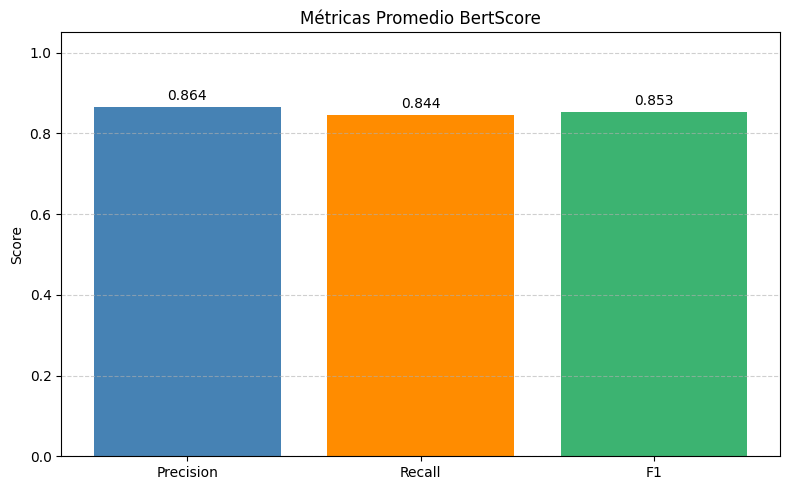

In [ ]:
import matplotlib.pyplot as plt

# calculate averages of each metrics
mean_precision = sum(results["precision"]) / len(results["precision"])
mean_recall = sum(results["recall"]) / len(results["recall"])
mean_f1 = sum(results["f1"]) / len(results["f1"])

# create bar plot
metrics = ['Precision', 'Recall', 'F1']
scores = [mean_precision, mean_recall, mean_f1]
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, scores, color=['steelblue', 'darkorange', 'mediumseagreen'])

# add tags
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{height:.3f}", ha='center', va='bottom')

# plot
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Métricas Promedio BertScore")  # print title in spanish to mix things up ;)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


We can interpret the results the following way:

* **Precision** measures the degree of semantic similarity between the generated response and the actual response. A score of 0.864 means the model generally manages to convey messages of fairly similar tone and meaning to the actual responses from the dataset.

* **Recall** measures the fraction of the information in the original message that the prediction conveys. A score of 0.844 means the model typically conveys the same information as the original sequence.

--------------
We could still explore a lot more aspects of this implementation, but I´m afraid this is all for now. 

Thank you for your attention! I hope this was useful or entertaining to read.